# Simon's Algorithm
<hr></hr>

[Simon's algorithm](https://en.wikipedia.org/wiki/Simon%27s_problem), introduced by Daniel R. Simon in 1994, was the first quantum algorithm shown to solve a problem **exponentially** faster than the best known classical methods [[Simon94]](https://epubs.siam.org/doi/pdf/10.1137/S0097539796298637). 

Although the problem tackled by this algorithm (known as Simon’s problem) has no direct practical relevance, its discovery laid the groundwork for Shor’s algorithm, one of the very few quantum algorithms with a proven advantage for a real-world application.

<a name="back1"></a> Simon's problem is similar to the Bernstein-Vazinari problem in that we are tasked with finding a secret string $s$. However, the function that encodes $s$ is different[$^*$](#footnote1). In Simon's problem, we are given a function that takes an $n$-bit input $x$ and produces an $n$-bit output $f(x)$ (i.e., $f: \{0, 1\}^n \longmapsto \{0, 1\}^n$) where we are promised that $f(x) = f(s \oplus x).$ Here, $s$ is an $n$-bit string different from $0$, and $\oplus$ denotes the bitwise XOR (addition modulo-2) operation:

$$ s \oplus x = \underbrace{s_{n-1} \oplus x_{n-1}}_{(n-1)^{\text{th}} \text{ bit}} \dots \underbrace{s_{1} \oplus x_{1}}_{1^{\text{st}} \text{ bit}} \, \underbrace{s_{0} \oplus x_{0}}_{0^{\text{th}} \text{ bit}} .$$

This condition guarantees that there will be two values of $x$ for which $f(x)$ takes the same value. In other words, the function $f(x)$ is two-to-one. For example, given the string $s = 110$ a possible valid function $f: \{0, 1\}^3 \longmapsto \{0, 1\}^3$, has the following associated mapping:

$$
\begin{split}
\begin{aligned}
f(000) &= 011
\\
f(001) &= 100
\\
f(010) &= 010
\\
f(011) &= 111
\\
f(100) &= 010
\\
f(101) &= 111
\\
f(110) &= 011
\\
f(111) &= 100
\end{aligned}
\end{split}
$$

Notice how, for example, for $x = 001$ and $x = (110 \oplus 001) = 111,$ we obtain the same $f(x) = 100.$ 

It is worth noting that, for the purpose of Simon's problem, the value that $f(x)$ takes for each individual $x$ is completely arbitrary as long as the condition $f(x) = f(s \oplus x)$ is met.

Let's now use python to generate an arbitrary function $f(x)$ for every possible value of $x$ given a string $s$:

In [1]:
import numpy as np

In [2]:
def fx_simon(s_int, n):
    fx_lst = [0]*2**n
    x_used = []
    fx_avail = list(range(2**n))
    
    for x_int in range(2**n):
        if x_int in x_used: continue

        x_pair = s_int ^ x_int
        x_used.extend((x_int, x_pair))
        
        # pick random f(x) value and remove from available list
        fx_int = np.random.choice(fx_avail)
        fx_avail.remove(fx_int)
        
        # assign f(x) value to x and s⊕x
        fx_lst[x_int] = fx_int
        fx_lst[x_pair] = fx_int
        
    return fx_lst

In [3]:
s = '1101'          # String (pick value different from all-zeros string).
n = len(s)
s_int = int(s, 2)

fx_lst = fx_simon(s_int, n)

print(f'Outcomes for s = {s}\n')
print('x',' '*(n), 'f(x)')

for x_int, fx_int in enumerate(fx_lst):
    x = np.binary_repr(x_int,n)
    fx = np.binary_repr(fx_int,n)
    
    print(x, ' ', fx)

Outcomes for s = 1101

x      f(x)
0000   1011
0001   1010
0010   0101
0011   0010
0100   1000
0101   1001
0110   1110
0111   0011
1000   1001
1001   1000
1010   0011
1011   1110
1100   1010
1101   1011
1110   0010
1111   0101


Rerunning the cell above will result different values of $f(x)$ (picked at random) for each corresponding $x$. However, the condition $f(x) = f(s \oplus x)$ is always fulfilled.

## 1. Classical Approach

To solve Simon's problem classically, we have to evaluate the function $f(x)$ for different input values until we get two values of $x$ that share the same output. If the inputs for which we get the same outcome are the pair $\{a, b\},$ we know that $f(a) = f(b).$ Now, since $f(x) = f(s \oplus x)$ for all values of $x,$ this implies that $b = s \oplus a$. We can then find $s$ by taking the **XOR** with $a$ on both sides of this expression:

$$ 
\begin{aligned}
b &= s \oplus a
\\
\\
b \oplus a &= (s \oplus a) \oplus a
\\
\\
b \oplus a &= s \oplus (a \oplus a)
\\
\\
b \oplus a &= s.
\end{aligned}
$$

This equality holds because taking the bitwise **XOR** of any number with itself is always zero (i.e., $a \oplus a = 0$).

So, if we get very lucky, it can take us only $2$ tries to find repeated outcomes that allows us to extract $s$ (best case scenario). However, since for a string of length $n$ we can have $2^n = 2^{n-1}$ different inputs for which there are $2^n/2$ corresponding $f(x)$ values (since $f(x)$ is two-to-one), it can take up to $2^{n-1} + 1$ tries to find the inputs for two matching outputs (worst case scenario). Later in this section we will explore how the probability of success changes for a given number of tries.

Similar to what we did for the Deutsch-Jozsa and Bernstein-Vazirani problems, we can encode the function $f(x)$ for Simon's problem into a unitary $U_f$ that we can either run as a classical reversible circuit, or use as part of a quantum algorithm:

<img src="images/04_03_01_simons_bb.png" align = "center" width="650"/>

Here, the top $n$ qubits (labeled $|x\rangle$) correspond to the function input, and the bottom $n$ qubits produce the output $|f(x)\rangle$ when $|y\rangle = |0\rangle^{\otimes n}.$

Let's now create a python function that naïvely encodes the $f(x) = f(s \oplus x)$ condition into $U_f$ (details on this and a more efficient implementation are discussed in section 1.3).

In [4]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

In [5]:
def black_box(n):
    # Black box of Simon's problem using naïve implementation.
    # It encodes it each product element from a sum of products asan MCX gate.
    s_int = np.random.randint(1, 2**n)
    s = np.binary_repr(s_int, n)
    
    fx_controls = [[] for _ in range(n)]
    fx_lst = fx_simon(s_int, n)
    
    # Iterate over fx_list where each index is x, value is integer value of fx
    # and find the control values for each fx_i that evaluates to 1.
    for x_int, fx in enumerate(fx_lst):
        for bit, fx_bit in enumerate(reversed(np.binary_repr(fx, n))):
            if fx_bit == '1':
                fx_controls[bit].append(x_int)
    
    qc_bb = QuantumCircuit(2*n, name='Black Box')
    for i, controls in enumerate(fx_controls):
        for int_ctrl_state in controls:
            ctrl_state = np.binary_repr(int_ctrl_state,n)
            qc_bb.mcx(list(range(n,2*n)),i,ctrl_state=ctrl_state)
        qc_bb.barrier()
        
    return qc_bb, s

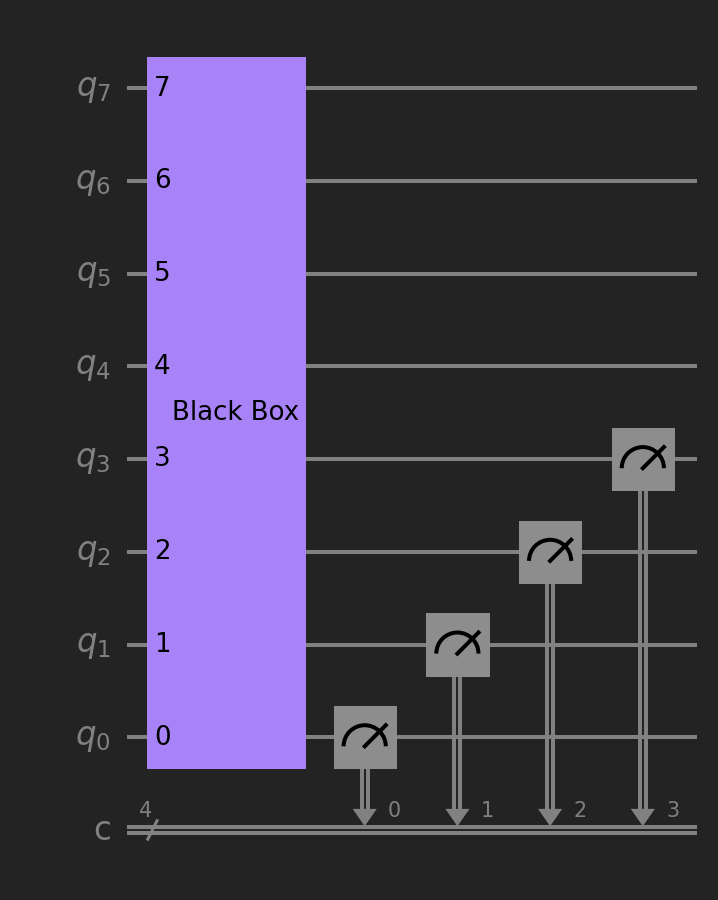

In [6]:
# Draw example circuit to solve B-V's problem classically (n = 4, x = 0000)
n = 4
bb, _ = black_box(n)

qc = QuantumCircuit(2*n,n)
qc.append(bb,range(2*n))
qc.measure(range(n),range(n))
qc.draw()

We can now try each possible classical input $x$ and check that, for the encoded string $s$, our unitary $U_f$ does correctly return a two-to-one function for which the condition $f(x) = f(s \oplus x)$ holds:

In [7]:
# Go over every input and output

n = 3                        # String length
bb, s = black_box(n)         # Generate black box and secret string
fx_meas = {}                 # Dict where keys are measured fx and values are corresponding x

simulator = AerSimulator()

print(f'Outcomes for s = {s}\n')
print('x',' '*(n), 'f(x)')
for x_int in range(2**n):
    
    x = np.binary_repr(x_int, n)
    input_ones = [i+n for i, v in enumerate(reversed(x)) if v == '1']
    
    qc = QuantumCircuit(2*n,n)
    if input_ones: qc.x(input_ones)
    qc.append(bb,range(2*n))
    qc.measure(range(n),range(n))
    
    qc_t = transpile(qc, simulator)
    job = simulator.run(qc_t, shots=1, memory=True)  # Run one simulation to get f(x) outcome
    fx = job.result().get_memory()[0]
    
    print(x, ' ', fx)

Outcomes for s = 100

x     f(x)
000   111
001   000
010   011
011   110
100   111
101   000
110   011
111   110


Let us now run a classical procedure to solve Simon's problem by picking different input values of $x$ at random until we find two matching values of $f(x).$ Once found, we can then extract the encoded secret string $s$ by taking the **XOR** between the two inputs that produced the matching outputs:

In [8]:
n = 7                        # String length
bb, s = black_box(n)         # Generate black box and secret string

fx_meas = {}                  # Dictionary to store string extracted from f(x) and the corresponding value of x
match = False                 # Has a match been found?
x_avail = list(range(2**n))   # List with all possible x values to try
tries = 0                     # Number of tries to find s

while not match:
    
    # pick x at random
    x_int = np.random.choice(x_avail)
    x_avail.remove(x_int)
    x = np.binary_repr(x_int, n)
    
    # evaluate Uf for selected x
    input_ones = [i+n for i, v in enumerate(reversed(x)) if v == '1']
    
    qc = QuantumCircuit(2*n,n)
    if input_ones: qc.x(input_ones)
        
    qc.append(bb,range(2*n))
    qc.measure(range(n),range(n))
    
    qc_t = transpile(qc, simulator)
    job = simulator.run(qc_t, shots=1, memory=True)
    fx = job.result().get_memory()[0]
    
    tries += 1
    
    if fx in fx_meas:
        s_out = np.binary_repr(x_int ^ int(fx_meas[fx], 2), n)
        match = True
    else:
        fx_meas[fx] = x
        
print(f'secret string: {s}')
print(f'extracted string: {s_out}')
print(f'number of tries: {tries} (out of {int(2**n/2)} possible outputs)')

secret string: 1101000
extracted string: 1101000
number of tries: 22 (out of 64 possible outputs)


Rerunning the cell above will always extract the secret string correctly, but the number of tries it'll take will vary.

Now, calculating the probability of classically finding a secret string of length $n$ after a certain number of tries $r$, is akin to solving the [birthday paradox problem](https://en.wikipedia.org/wiki/Birthday_problem), but where the sample space changes as a function of the number of extracted values $k$:

$$ \mathbb{P}_{\text{success}} =  1 - \prod_{k=0}^{r-1}\frac{2^n - 2 k}{2^n - k}$$

The details of how this expression is obtained are out of the scope of our discussion. What's critical here, is that this equation shows that for a string of length $n$, it takes roughly $ r \sim \sqrt{2^{n}} = 2^{n/2}$ tries to find $s$ with more than $50 \%$ probability. This means that with a classical approach, the number of tries needed to successfully find $s$ with high probability grows **exponentially** with the length of the string $n.$ 

The plot below shows the simulation result for the probability of finding a secret string of length $n = 5$ after a certain number of tries $r:$
<img src="images/04_03_02_classical_probs.png" align = "center" width="520"/>

It can be seen that only after $r = 6$ tries, the probability of success is over $50 \%,$ which is close to the expectation of requiring a value larger than $2^{5/2} \approx 5.66.$

## 2. Quantum Approach

In contrast to the Deutsch-Jozsa and Bernstein-Vazirani algorithms (which yield a solution in single try), Simon's algorithm requires multiple accesses to the unitary $U_f$ in order to determine the secret string $s$ with high probability. However, unlike the classical approach we described above (which needs a number of function evaluations that grows exponentially with $n$), Simon's algorithm only requires an average number of calls to $U_f$ that grows linearly with $n.$ We will also see that, in contrast to previous quantum algorithms, Simon's algorithm relies on classical post-processing steps, where the measurement outcomes of multiple quantum circuit runs are used to compute $s.$

### 2.1. Quantum Circuit

The quantum circuit utilized in Simon's algorithm is similar to that of the Deutsch-Jozsa and Bernstein-Vazinari algorithms in that we place the top register $x$ in superposition, evaluate $U_f,$ and then perform interference. 

<img src="images/04_03_03_simon.png" align = "center" width="520"/>

However, the circuit is different in that we do not prepare the bottom register $y$ in an eigenstate of $U_f$ to perform phase kickback. Instead, we initialize them in the all-zeros state $|0\rangle^{\otimes n}$ and measure them right after the function evaluation takes place.

To understand the reasoning for this approach, lets analyze the circuit step by step for an arbitrary number of bits $n$. In [section 1.2.3](#1.2.3-Numerical-Example) we will go over a concrete example using 3 qubits to clarify the process.

0. Initialize both qubit registers in the all-zeros state: 

$$ |\psi\rangle_0 = |0\rangle^{\otimes n} \otimes |0\rangle^{\otimes n} $$

1. Place top register $x$ in a uniform superposition:

$$ 
\begin{aligned}
|\psi\rangle_1 &= \text{QHT}_n |0\rangle^{\otimes n} \otimes |0\rangle^{\otimes n} 
\\
\\
|\psi\rangle_1 &=  \left( \frac{1}{\sqrt{N}} \sum_{x = 0}^{N - 1} |x\rangle \right) \otimes |0\rangle^{\otimes n}; \; N = 2^n.  
\end{aligned}
$$

2. Evolve the state over $U_f$: 

$$ 
\begin{aligned}
|\psi\rangle_2 &= U_f |\psi\rangle_1
\\
\\
|\psi\rangle_2 &=  \frac{1}{\sqrt{N}} \sum_{x = 0}^{N - 1} |x\rangle \otimes |f(x)\rangle.
\end{aligned}
$$

Here, $|\psi\rangle_2$ is a superposition state over all possible $|x\rangle$ values and their corresponding $|f(x)\rangle$. Now, since our function meets the condition $f(x) = f(s \oplus x),$ we know that every state $|x\rangle$ will have a corresponding $|s \oplus x\rangle$ that shares the same $|f(x)\rangle.$ Therefore, we can rewrite the expression above as:

$$ |\psi\rangle_2 =  \frac{1}{\sqrt{N}} \sum_{x \in S} \big( |x\rangle + |s \oplus x\rangle \big) \otimes |f(x)\rangle, $$

where $S$ is a set that contains half of the values $x$ can take (and which depends on the string $s$).

3. Next, we measure the bottom register $y,$ which will cause the superposition state $|\psi\rangle_2$ to be projected onto a state with a **single value** of $f(x).$ Let's call this state $|f(a)\rangle,$ where $a$ is some arbitrary value of $x.$ This leaves the top register $x$ in a superposition of the **two states** that evaluate to the same $f(a)$:

$$ |\psi\rangle_3 = \frac{1}{\sqrt{2}} \big(|a\rangle + |s\oplus a\rangle \big) \otimes |f(a)\rangle .$$

For the remaining of the analysis, we can drop the state of the bottom register since it has already been measured, leaving us with $ |\psi\rangle_3 = \frac{1}{\sqrt{2}} \left(|a\rangle + |s\oplus a\rangle \right).$

4. We perform interference by applying the $\text{QHT}$ to the top register:

$$ 
\begin{aligned}
|\psi\rangle_4 &= \text{QHT}_n|\psi\rangle_3
\\
\\
|\psi\rangle_4 &= \frac{1}{\sqrt{2}} \big(\text{QHT}_n|a\rangle + \text{QHT}_n|s\oplus a\rangle \big)
\\
\\
|\psi\rangle_4 &= \frac{1}{\sqrt{2}} \left(\frac{1}{\sqrt{N}} \sum_{z = 0}^{N - 1} (-1)^{a \cdot z} |z\rangle + \frac{1}{\sqrt{N}} \sum_{z = 0}^{N - 1} (-1)^{(s \oplus a) \cdot z} |z\rangle \right)
\\
\\
|\psi\rangle_4 &= \frac{1}{\sqrt{2 N}} \sum_{z = 0}^{N - 1} \left[ (-1)^{a \cdot z} + (-1)^{(s \oplus a)\cdot z} \right] |z\rangle
\\
\\
|\psi\rangle_4 &= \frac{1}{\sqrt{2 N}} \sum_{z = 0}^{N - 1} (-1)^{a \cdot z} \left[1 + (-1)^{s \cdot z} \right] |z\rangle
\end{aligned}
$$

If we now focus on the probability amplitude expression inside the square brackets, we see that we have two possibilities:

- if $(s \cdot z) = 1,$ then $\left[1 + (-1)^{s \cdot z} \right] = 0, $
- if $(s \cdot z) = 0,$ then $\left[1 + (-1)^{s \cdot z} \right] = 2 .$

What this means is that, all the $|z\rangle$ terms in the summation for which the dot product between $s$ and $z$ is $1$, vanish. This leaves us with a state where only the terms for which $s \cdot z = 0$ survive:

$$ |\psi\rangle_4 = \frac{2}{\sqrt{2 N}} \sum_{\; z | (s \cdot z = 0)} (-1)^{a \cdot z} |z\rangle. $$

Here it is worth noting that, regardless of the value of the string $s$, the expression $s \cdot z = 0$ always holds for $z = 0$. Therefore, one of the terms that is always present in the superposition is the all-zeros string $|z\rangle = |0\rangle^{\otimes n}.$ As a matter of convenience, we can pull this term out from the summation to make this explicit:

$$ |\psi\rangle_4 = \frac{1}{\sqrt{N/2}}\Big(|0\rangle^{\otimes n} + \sum_{\; z | (s \cdot z = 0), \\ \; \text{and } z \neq 0} (-1)^{a \cdot z} |z\rangle \Big). $$

5. The final step in the circuit is to measure state $|\psi\rangle_4$, which produces one of two types of outcomes:

- With probability $\left|\frac{1}{\sqrt{N/2}}\right|^2 = \frac{2}{N},$ we measure the all-zeros string $|0\rangle^{\otimes n}.$
- With probability $1 - \frac{2}{N},$ we measure some other state $|z\rangle$ for which the equation $s \cdot z = 0$ holds.

The first case is considered a "failed" attempt since it gives us no information whatsoever about the string $s.$ This means that, if we execute the circuit and measure $z = 0 \dots 00,$ we need to re-run the circuit.

The second case, on the other hand, provides us with a classical binary string $z = z_{n-1} ... z_1 z_0$ that meets the condition:

$$ 
\begin{aligned}
s \cdot z &= z_{n-1} s_{n-1} \oplus \dots \oplus z_{1} s_{1} \oplus z_{0} s_{0} = 0.
\end{aligned}
$$

This basically corresponds to a linear equation (modulo 2), where each $z_i$ is a coefficient equal to $0$ or $1,$ and each $s_i$ is an unknown variable. We can then execute Simon's quantum circuit several times to extract different values of $z$ that allow us to form a system of $n-1$ linearly-independent equations:

$$ 
\begin{aligned}
z_{n-1}^{(1)} s_{n-1} \oplus \dots \oplus \, & z_{1}^{(1)} s_{1} \oplus z_{0}^{(1)} s_{0} = 0
\\
\\
z_{n-1}^{(2)} s_{n-1} \oplus \dots \oplus \, & z_{1}^{(2)} s_{1} \oplus z_{0}^{(2)} s_{0} = 0
\\
&\vdots
\\
z_{n-1}^{(n-1)} s_{n-1} \oplus \dots \oplus \, & z_{1}^{(n-1)} s_{1} \oplus z_{0}^{(n-1)} s_{0} = 0.
\end{aligned}
$$

Here, the superscripts $j$ (in $z^{(j)}$) are used to represent the different $z$ strings measured after executing the quantum circuit. Solving this system of equations gives us as a solution the $n$ bits of $s.$

As mentioned before, every time we measure the all-zero strings or get a repeated value of $z$, we must re-execute the circuit. However, since we only need $n - 1$ equations to find $s$, the number of calls will be much smaller (linear in $n$) compared to the number of calls we needed classically (exponential in $n$). 

So in addition to executing the quantum circuit, we also need a procedure that, a) verifies that every measured $z$ is not the all-zeros string or a repeated value of $z$, b) checks that every new $z$ is linearly-independent from previous measured values (explained in the next section), c) stores every valid $z$ until we have $n-1$ results and, e) solves the resulting linear system of equations. Let's cover these steps in more detail in the next section.

### 2.2. Classical Post-Processing

From the explanation above, it is clear that Simon's algorithm requires a combination of quantum and classical steps. As a matter of fact, the flow chart below shows that the quantum circuit is only a portion of a larger hybrid process:

<img src="images/04_03_04_full_simon.png" align = "center" width="900"/>

Let's go over each of the steps:

1. The algorithm starts by checking if the number of stored `z` outputs (tracked by the value `k`) is already equal to the minimum number of linearly-independent equations (`n - 1`) required to find the `n` bits of the string `s`.

2. If the condition above is **not** met, Simon's circuit is executed to extract a new output `z`.

3. The next step checks if the new circuit outcome `z` is **not** the all-zeros string **and** is **not** already in the list of stored values `z_lst`. If these conditions are met, the algorithm proceeds. If it fails, the circuit must be rerun.

4. Next, it must be verified if `z` is linearly-independent from all previous values stored in `z_lst` (more on this below). If not, the circuit must be re-executed.

5. If step 4 passes, `z` is stored in `z_lst` and `k` is incremented. All steps above must be repeated until `k = n - 1`.

6. Once all necessary values of `z` are available, the algorithm proceeds to solve the linear system of equations and find `s`.

Steps 1, 2, and 3 were described in detail in the previous section, so we can now focus on the classical post-processing steps involved in finding the $n - 1$ linearly-independent equations, and solving the system to find $s$.

Now, the reason why we check for linear independence is because, an equation generated by new value of $z$ that can be expressed as a linear combination of previous results, doesn't provide any new information about how to solve for $s$. However, let's start by first analyzing the case where, instead of checking right away if every new outcome is linearly independent from previous ones, we collect $m$ unique values of $z$, where $m$ much larger than the required $n-1$ linearly-independent equations. In other words, we skip step 4 altogether and collect many samples of $z$ with the hope that $n - 1$ of these will generate linearly-independent equations. Now, even if some of our outcomes are not linearly independent, we know that each of them still generate an equation of the form $z^{(j)} \cdot s = 0: $

$$ z_{n-1}^{(j)} s_{n-1} \oplus \dots \oplus z_{1}^{(j)} s_{1} \oplus z_{0}^{(j)} s_{0} = 0. $$

We can rewrite this expression as the dot product (modulo 2) of two binary vectors $\vec{z}^{(j)}$ and $\vec{s},$ where their entries are the bits of $z$ and $s$, respectively: $\vec{z}^{(j)} \cdot \vec{s} = 0 .$ Written in vector form:

$$ 
\begin{aligned}
\begin{bmatrix} z_{0}^{(j)} & z_{1}^{(j)} & \dots & z_{n-1}^{(j)} \end{bmatrix} \begin{bmatrix} s_{0} \\ s_{1} \\ \vdots \\ s_{n-1} \end{bmatrix} &= 0
\end{aligned}
$$

We can then organize the $m$ different equations by stacking each $\vec{z}^{(j)}$ as rows in a matrix:

$$
\begin{bmatrix}
z_{0}^{(1)} & z_{1}^{(1)} & \dots & z_{n-1}^{(1)} \\
z_{0}^{(2)} & z_{1}^{(2)} & \dots & z_{n-1}^{(2)} \\
\vdots      & \vdots      & \ddots & \vdots \\
z_{0}^{(n-1)} & z_{1}^{(n-1)} & \dots & z_{n-1}^{(n-1)} \\
\vdots      & \vdots      & \ddots & \vdots \\
z_{0}^{(m)} & z_{1}^{(m)} & \dots  & z_{n-1}^{(m)}
\end{bmatrix}
\begin{bmatrix} s_{0} \\ s_{1} \\ \vdots \\ s_{n-1} \end{bmatrix} = 
\begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix}
$$

This expression is of the form $Z \vec{s} = \vec{0},$ which is convenient because it allows us to use linear algebra technique to find the unknown vector $\vec{s}.$ More explicitly, $\vec{s}$ can be found by computing the [kernel](https://en.wikipedia.org/wiki/Kernel_(linear_algebra)#Representation_as_matrix_multiplication) of the matrix $Z.$ Here, the kernel is nothing other than the group of vectors that, when multiplied by $Z,$ result in the all-zeros vector.

The first step to computing the kernel of a matrix is to express it in what is known as its [reduced row echelon form (RREF)](https://en.wikipedia.org/wiki/Row_echelon_form#Reduced_row_echelon_form) through [Gauss-Jordan elimination](https://en.wikipedia.org/wiki/Gaussian_elimination#Gauss–Jordan_elimination). Here we won't focus on the details of how this is done; all we need to know is that, if our $m$ collected samples of $z$ contain $n - 1$ values that are linearly-independent, the RREF of $Z$ will be a matrix where the first $n-1$ rows correspond to a set of new basis vectors $\vec{\zeta}^{(j)},$ and the remaining $ m - (n - 1) $ rows are all $0:$

$$
\begin{bmatrix}
z_{0}^{(1)} & z_{1}^{(1)} & \dots & z_{n-1}^{(1)} \\
z_{0}^{(2)} & z_{1}^{(2)} & \dots & z_{n-1}^{(2)} \\
\vdots      & \vdots      & \ddots & \vdots \\
z_{0}^{(n-1)} & z_{1}^{(n-1)} & \dots & z_{n-1}^{(n-1)} \\
\vdots      & \vdots      & \dots & \vdots \\
\vdots      & \vdots      & \ddots & \vdots \\
z_{0}^{(m)} & z_{1}^{(m)} & \dots  & z_{n-1}^{(m)}
\end{bmatrix}
\;\xrightarrow{\text{RREF}}\;
\begin{bmatrix}
\zeta_{0}^{(1)} & \zeta_{1}^{(1)} & \dots & \zeta_{n-1}^{(1)} \\
\zeta_{0}^{(2)} & \zeta_{1}^{(1)} & \dots & \zeta_{n-1}^{(1)} \\
\vdots          & \vdots          & \ddots & \vdots \\
\zeta_{0}^{(n-1)} & \zeta_{1}^{(n-1)} & \dots & \zeta_{n-1}^{(n-1)} \\
0 & 0 & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & 0
\end{bmatrix}
$$

In the end, the basis vectors $\vec{\zeta}^{(j)}$ will form the $n - 1$ linearly independent expressions we need to solve for $\vec{s}$.

Now, selecting an optimal value for $m$ can be tricky because, if we pick it to be too small, there is a chance that we will not obtain the $n - 1$ linearly-independent values of $z$ we need to solve the system of equations. On the other hand, if we pick it too large, we can end up with several linearly-**dependent** samples, which do not provide us any additional basis vectors $\vec{\zeta}.$ So what we can do, is compute the basis vectors on the fly. Every time we sample a new $z$ from our circuit, we perform Gaussian elimination. If the process results in a new basis vector, we store it; if not, we execute the circuit again to obtain a new $z$ and repeat the process until we have the $n - 1$ basis vectors we need. These are basically steps 4 and 5, so all we have left is to perform step 6, which entails solving for $\vec{s}$ in the vector equation $Z\vec{s} = \vec{0}$ via back-substitution, but where we replace the matrix $Z$ with its corresponding RREF:

$$
\begin{bmatrix} \zeta_{0}^{(1)} & \zeta_{1}^{(1)} & \dots & \zeta_{n-1}^{(1)} \\
                \zeta_{0}^{(2)} & \zeta_{1}^{(2)} & \dots & \zeta_{n-1}^{(2)} \\
                \vdots & \vdots & \ddots & \vdots \\
                \zeta_{0}^{(n-1)} & \zeta_{1}^{(n-1)} & \dots & \zeta_{n-1}^{(n-1)} \end{bmatrix} 
\begin{bmatrix} s_{0} \\ s_{1} \\ \vdots \\ s_{n-1} \end{bmatrix} = 
\begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix} .
$$

Let's now take a look at a concrete numerical example of the full algorithm to get a better understanding of how each step works.

### 2.3. Numerical Example

Let's start by assuming that we are given access to a unitary $U_f$ which encodes a function $f(x).$ We are promised that function satisfies the condition for Simon's problem $f(x) = f(s \oplus x)$ for a secret string $s = 1010,$ and has the following input/output relation:

$$
\begin{array}{|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
\hline
x & 0000 & 0001 & 0010 & 0011 & 0100 & 0101 & 0110 & 0111 & 1000 & 1001 & 1010 & 1011 & 1100 & 1101 & 1110 & 1111 \\
\hline
f(x) & 1001 & 1010 & 1000 & 1011 & 0111 & 0011 & 0110 & 1110 & 1000 & 1011 & 1001 & 1010 & 0110 & 1110 & 0111 & 0011 \\ 
\hline
\end{array}
$$

#### Quantum Circuit Analysis

Since $x$ and $f(x)$ encode $4$ bits each, the unitary $U_f$ that encodes the function (and therefore, our quantum circuit) must have a total of $8$ qubits. Let's go over each of the steps we described in [section 1.2.1](#1.2.1-Quantum-Circuit):

0. Initialize the circuit qubits in the all-zeros state:

$$ |\psi\rangle_0 = |0000\rangle \otimes |0000\rangle .$$

1. Apply the $\text{QHT}$ to place top register in a uniform superposition:

$$
\begin{aligned}
|\psi\rangle_1 &=  \left( \frac{1}{\sqrt{2^4}} \sum_{x = 0}^{2^4 - 1} |x\rangle \right) \otimes |0000\rangle
\end{aligned}
$$

writing out each term explicitly:

$$
\begin{aligned}
|\psi\rangle_1  =  \frac{1}{4} \big(
&|0000\rangle + |0001\rangle + |0010\rangle + |0011\rangle \, + \\
&|0100\rangle + |0101\rangle + |0110\rangle + |0111\rangle \, + \\
&|1000\rangle + |1001\rangle + |1010\rangle + |1011\rangle \, + \\
&|1100\rangle +  |1101\rangle + |1110\rangle + |1111\rangle 
\big) \otimes |0000\rangle .
\end{aligned}
$$

2. Evolve the state through $U_f,$ which basically pairs up each $|x\rangle$ with its corresponding $|f(x)\rangle$ (given in the table above).

$$
\begin{aligned}
|\psi\rangle_2  = \frac{1}{4} \big(
&|0000\rangle|1001\rangle + |0001\rangle|1010\rangle + |0010\rangle|1000\rangle + |0011\rangle|1011\rangle \, + \\
&|0100\rangle|0111\rangle + |0101\rangle|0011\rangle + |0110\rangle|0110\rangle + |0111\rangle|1110\rangle \, + \\
&|1000\rangle|1000\rangle + |1001\rangle|1011\rangle + |1010\rangle|1001\rangle + |1011\rangle|1010\rangle \, + \\ &|1100\rangle|0110\rangle + |1101\rangle|1110\rangle + |1110\rangle|0111\rangle + |1111\rangle|0011\rangle \big) .
\end{aligned}
$$

3. Measure the bottom register, which projects the state onto a single value $|f(a)\rangle$ and places the top register in a superposition of $|x\rangle$ and $|s \oplus x\rangle .$ Let's assume that, after the first execution, the measured value was $f(a) = 1011,$ resulting in the state:

$$ |\psi\rangle_3 = \frac{1}{\sqrt{2}} \big(|0011\rangle + |1001\rangle \big) \otimes |1011\rangle .$$

4. Apply the $\text{QHT}$ on the top register:

$$ 
\begin{aligned}
|\psi\rangle_4 = \frac{1}{\sqrt{8}} \big(
&|0000\rangle - |0001\rangle + |0100\rangle - |0101\rangle \, - \\ 
&|1010\rangle + |1011\rangle - |1110\rangle + |1111\rangle \big) .
\end{aligned}
$$

At this point it is worth pausing to highlight that, when we rerun the circuit, step 3 will likely result in a measurement that returns a different value of $f(x)$. However, the superposition we obtain in step 4 will always be composed by the same basis states, just with different relative phases! This is because Simon's circuit is designed to always result in a superposition of states $|z\rangle$ that meet the condition $s \cdot z = 0,$ independent of the measured value $f(x).$ For example, let's assume that after a executing the circuit again, in step 3 we measure $f(b) = 1110,$ resulting in the following state:

$$ |\psi\rangle_3 = \frac{1}{\sqrt{2}} \big(|0111\rangle + |1101\rangle \big) \otimes |1110\rangle .$$

Applying the $\text{QHT}$ on the top register gives us:

$$ 
\begin{aligned}
|\psi\rangle_4 = \frac{1}{\sqrt{8}} \big(
&|0000\rangle - |0001\rangle - |0100\rangle + |0101\rangle \, - \\ 
&|1010\rangle + |1011\rangle + |1110\rangle - |1111\rangle \big) ,
\end{aligned}
$$

which has the same components we obtained in the first run. 

So, independent of what value of $f(x)$ we measure, the state we get in step 4 is **always** a superposition of the same components: $\{|0000\rangle,$ $|0001\rangle,$ $|0100\rangle,$ $|0101\rangle,$ $|1010\rangle,$ $|1011\rangle,$ $|1110\rangle,$ $|1111\rangle \}.$

5. The last step in the quantum circuit is to measure the top register, which will result in either:

- The string $z = 0000$ with probability $|\frac{1}{\sqrt{8}}|^2 = \frac{1}{8},$ providing no information about the secret string $s.$
- A $z$ string from the list $\{0001,$ $0100,$ $0101,$ $1010,$ $1011,$ $1110,$ $1111\}$ with probability $\frac{7}{8},$ which we can use in the classical post-processing steps to extract $s$.

#### Classical Processing Analysis

From the analysis above, we know that every time we run the quantum circuit we get one of the following outcomes:

$$z \in \{0000, 0001, 0100, 0101, 1010, 1011, 1110, 1111\} .$$

- Lets assume that after the first run, we obtain outcome: $z^{(1)} = 0001.$ This gives us our first linear equation:

$$ 
\begin{aligned}
0 \cdot s_3 \oplus 0 \cdot s_2 \oplus 0 \cdot s_1 \oplus 1 \cdot s_0 = 0 
\\
\\
s_0 = 0.
\end{aligned}
$$

- We run the circuit again and obtain $z^{(2)} = 1010,$ with a corresponding equation:

$$
\begin{aligned}
1 \cdot s_3 \oplus 0 \cdot s_2 \oplus 1 \cdot s_1 \oplus 0 \cdot s_0 = 0 
\\
\\
s_3 \oplus s_1 = 0.
\end{aligned}
$$

- We run the circuit a third time and get $z^{(3)} = 1011,$ which results in:

$$
\begin{aligned}
1 \cdot s_3 \oplus 0 \cdot s_2 \oplus 1 \cdot s_1 \oplus 1 \cdot s_0 = 0 
\\
\\
s_3 \oplus s_1 \oplus s_0 = 0.
\end{aligned}
$$

Since this equation is a linear combination of the previous two, it gives us no new information to solve for $s$ (since we already knew that $s_3 \oplus s_1 = 0$ and $s_0 = 0$). We then need to get a new sample from the quantum circuit.

- A fourth run returns outcome $z^{(4)} = 1110,$ with equation:

$$
\begin{aligned}
1 \cdot s_3 \oplus 1 \cdot s_2 \oplus 1 \cdot s_1 \oplus 0 \cdot s_0 = 0 
\\
\\
s_3 \oplus s_2 \oplus s_1 = 0.
\end{aligned}
$$

Given that we know $s_3 \oplus s_1 = 0,$ this guarantees that $s_2 = 0.$ This also reveals that $s_3$ and $s_1$ must both equal $1$ because if they were both $0,$ the string $s$ would be the all-zeros string, which we know is not an allowed solution.

This reveals that our secret string is $s = 1010,$ as expected.

So far, we explained the post-processing steps in an intuitive way tracking each of the obtained equations. But we can also follow the procedure covered in [section 1.2.2](#1.2.2-Classical-Post-Processing), where we find a series of $n - 1$ basis vectors $\vec{\zeta}$ and solve a matrix equation.

- In the first step above we obtained $z^{(1)} = 0001.$ Since we don't have any other basis vectors yet, we store it:

$$\vec{\zeta}^{(1)} = \begin{bmatrix} 1 & 0 & 0 & 0  \end{bmatrix}^{\top} .$$

**NOTE:** In the vector notation we've followed so far, we place the least significant bit of $z$ as the first vector element. That's why the order might seem reversed.

- The second step gave the value $z^{(2)} = 1010.$ We then stack this and the previous stored vector on a matrix and perform Gaussian elimination. Now, since $z^{(2)}$ is linearly-independent from $\vec{\zeta}^{(1)},$ we find that new basis vector that is identical to $\vec{z}^{(2)}$, so we store it:

$$\vec{\zeta}^{(2)} = \begin{bmatrix} 0 & 1 & 0 & 1  \end{bmatrix}^{\top} .$$

- In the third run, we got $z^{(3)} = 1011,$ which is a linear combination of $\zeta^{(1)}$ and $\zeta^{(2)}.$ So, if we were to run Gaussian elimination between $\vec{\zeta}^{(3)}$ and the basis vectors $\vec{\zeta}^{(1)}, \vec{\zeta}^{(2)},$ we will get an all-zeros vector, which we discard.

- Lastly, in the fourth run, we obtained $z^{(4)} = 1110.$ Running Gaussian elimination between $\vec{z}^{(4)}$ and $\vec{\zeta}^{(1)}$, $\vec{\zeta}^{(2)}$, results in a new basis vector:

$$\vec{\zeta}^{(3)} = \begin{bmatrix} 0 & 0 & 1 & 0  \end{bmatrix}^{\top} .$$

We now have the $n - 1 = 3$ basis vectors we need to form our RREF matrix and solve for $s:$

$$
\begin{aligned}
\begin{bmatrix} 1 & 0 & 0 & 0 \\
                0 & 1 & 0 & 1 \\
                0 & 0 & 1 & 0 \\ \end{bmatrix}
\begin{bmatrix} s_{0} \\ s_{1} \\ s_{2} \\ s_{3} \end{bmatrix} &= 
\begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \end{bmatrix} 
\\
\\
\begin{bmatrix} s_{0} \\ s_{1} \\ s_{2} \\ s_{3} \end{bmatrix} &= 
\begin{bmatrix} 0 \\ 1 \\ 0 \\ 1 \end{bmatrix}.
\end{aligned}
$$

As expected, we get the string $s = 1010.$

### 2.4 Python Implementation

First, let's create a function that generates Simon's quantum circuit:

In [9]:
def simons_cir(n):
    bb, s = black_box(n)                     # generate random black-box of n input qubits
    
    qc_s = QuantumCircuit(2*n,2*n)
    qc_s.h(range(n,2*n))                     # Hadamard gates top n qubits
    qc_s.append(bb,range(2*n))               # append black box to circuit
    qc_s.measure(range(n),range(n))          # measure bottom n qubits
    qc_s.barrier()
    qc_s.h(range(n,2*n))                     # Hadamard gates on top n qubits
    qc_s.measure(range(n,2*n),range(n,2*n))  # measure top n qubits
    
    return qc_s, s

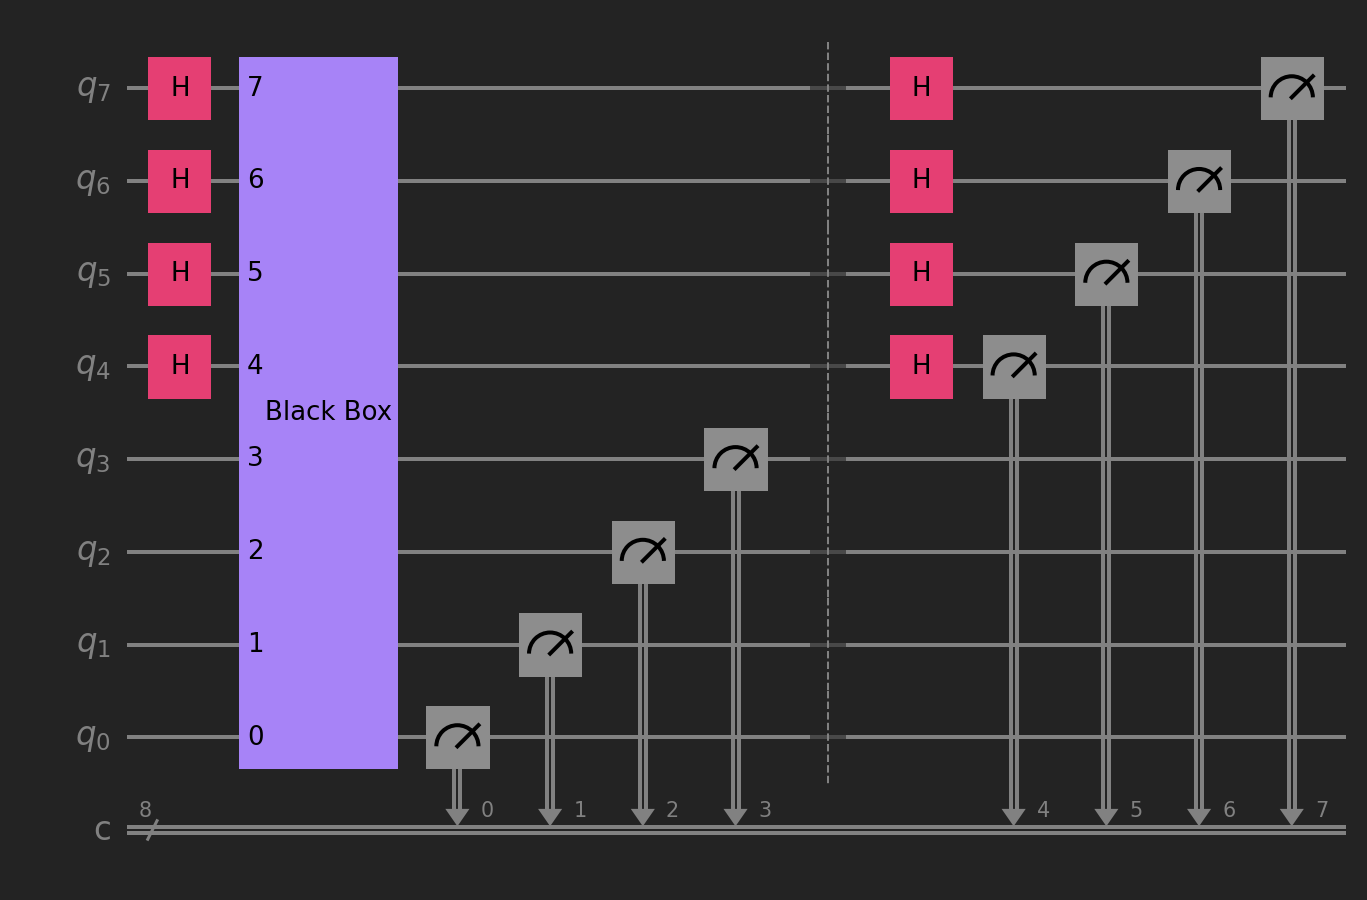

In [10]:
# Draw example of Simon's circuit for 4 qubits
qc = simons_cir(4)[0]
qc.draw()

In addition to the quantum circuit, we need two classical helper functions. The first one (`generate_basis`), checks that if output of the circuit is a value that is linearly independent from previous results, and generates an updated list of basis vectors that includes the new reduced vector.

The second function (`kernel_from_basis`) is used to compute the secret string $s$ by finding the kernel of the matrix that contains as its rows the $n - 1$ basis vectors obtained from the previous steps.

In [11]:
def generate_basis(basis: list[int], z: int):
    # Returns updated list of binary basis vectors by reducing a new entry `z` through
    # Gaussian elimination (mod 2). For convenience, we treat each "vector" as an integer,
    # where the bits of its binary representation correspond to the elements of the vector.
    
    basis = basis.copy()
    
    # Reduce z using existing pivots
    for b in basis:
        p = (b & -b).bit_length() - 1   # finds index of the lsb that's equal to 1 (pivot)
        if (z >> p) & 1:                # checks if the p^th bit of z is 1
            z ^= b                      # reduce z by XOR with basis vector b
            
    if z == 0: return basis             # If reduced z is zero, it was dependent
    p = (z & -z).bit_length() - 1       # finds index of the lsb that's equal to 1 (pivot)
    
    
    # Eliminate pivot from existing basis vectors (now z contains it)
    for i, b in enumerate(basis):
        if (b >> p) & 1:
            basis[i] ^= z
    
    basis.append(z)
    return basis

In [12]:
def kernel_from_basis(basis: list[int], n:int):
    # Returns the secret string s: int, which is the kernel of the RREF matrix
    # containing the basis vectors in `basis`. n is the number of bits in the secret string.
    # For convenience, we treat each "vector" as an integer, where the bits of its
    # binary representation correspond to the elements of the vector.

    # Find pivot positions
    pivots = []
    for b in basis:
        if b == 0:
            continue
        p = (b & -b).bit_length() - 1  # finds index of the lsb that's equal to 1 (pivot)
        pivots.append(p)

    pivot_set = set(pivots)

    # Find free positions
    free_positions = [j for j in range(n) if j not in pivot_set]

    # Build kernel vectors
    kernel_basis = []
    for free in free_positions:
        s = 1 << free  # set free variable to 1

        # solve pivot variables
        for b, p in zip(basis, pivots):
            if (b >> free) & 1:
                s ^= (1 << p)

        kernel_basis.append(s)

    return kernel_basis

We can now put everything together by combining the quantum circuit with the classical-post processing steps:

In [13]:
n = 7            # Length of secret string s
k = 0            # Number of linearly-independent values found
tries = 0        # Number of tries to find s
basis_vects = [] # List of vectors representing system of linear equations

simulator = AerSimulator()

qc_s_cir, s = simons_cir(n)   # Generate Simon's circuit for a random string s

while k < n - 1:
    
    # transpile and run quantum circuit
    qc_t = transpile(qc_s_cir, simulator)
    job = simulator.run(qc_t, shots=1, memory=True)
    z_and_fx = job.result().get_memory()[0]   # returns results for both top and bottom registers
    z = int(z_and_fx[0:n], 2)                 # extract z only (as integer)
    
    if z != 0:
        basis_vects = generate_basis(basis_vects, z)
        k = len(basis_vects)
        
    tries += 1

s_out = np.binary_repr(kernel_from_basis(basis_vects, n)[0],n)
        
print(f'secret string: {s}')
print(f'extracted string: {s_out}')
print(f'number of tries: {tries} (out of {int(2**n/2)} possible outputs)')

secret string: 0111110
extracted string: 0111110
number of tries: 6 (out of 64 possible outputs)


Even for small values of $n$, we can check that the quantum algorithm performs better than its classical counterpart by running the code above and computing the probability of success for a given number of tries $r$. The plot below shows the results for a simulation with $n = 5,$ which compared to the plot in [section 1.1](#1.1-Classical-Approach) provides a much higher probability of success at lower values of $r.$

<img src="images/04_03_05_quantum_probs.png" align = "center" width="520"/>

It is also worth noting that for the quantum algorithm, the probability of success will always be zero for $r < n - 1$ because we need to collect at least $n - 1$ samples to solve the linear system of equations. When placing the results for the classical and quantum algorithms this difference becomes obvious. For $n = 7,$ the probability of success for the quantum algorithm is $0$ before $r = 6$, but after that, it passes the $50 \%$ mark at $r = 7 .$ In contrast, the classical approach requires $r = 14$ tries to succeed more than $50 \%$ of the time.

<img src="images/04_03_06_compare_probs.png" align = "center" width="750"/>

## 3 Comments on Black Box Implementation

In this section, we will discuss the details of how to implement the unitary $U_f$ that encodes the function for Simon's problem $f(x) = f(s \oplus x)$.

Let's consider the most general case in which, instead of getting an explicit Boolean function, we are given the input/output (Truth Table) for the bits of $f(x).$ For example, we are given the following relation:

$$
\begin{array}{|ccc|ccc|}
\hline
x_2 & x_1 & x_0 & f(x)_2 & f(x)_1 & f(x)_0 \\
\hline
% values go here
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 1 & 1 & 0 \\
0 & 1 & 0 & 0 & 1 & 0 \\
0 & 1 & 1 & 1 & 0 & 1 \\
1 & 0 & 0 & 0 & 0 & 0 \\
1 & 0 & 1 & 0 & 1 & 0 \\
1 & 1 & 0 & 1 & 1 & 0 \\
1 & 1 & 1 & 1 & 0 & 1 \\
\hline
\end{array}
$$

This truth table corresponds to a function that meets the constraint $f(x) = f(s \oplus x)$ when s = $100.$

To construct the circuit for the unitary $U_f$, we will need two 3-qubit registers; one for the input bits $x_0, x_1, x_2$ and one to evaluate the outputs $f(x)_0, f(x)_1, f(x)_2.$ 

We can then use a simple approach and first find the Boolean expressions for each output $f(x)_i$ that evaluates to $1$ as a sum of products (i.e., find the [Disjunctive normal form (DNF)](https://en.wikipedia.org/wiki/Disjunctive_normal_form) by semantic means):

$$ 
\begin{aligned}
f(x)_0 &= \left( \overline{x_2} \land x_1 \land x_0 \right) \lor \left(x_2 \land x_1 \land x_0 \right).
\\
\\
f(x)_1 &= \left( \overline{x_2} \land \overline{x_1} \land x_0 \right) \lor \left( \overline{x_2} \land x_1 \land \overline{x_0} \right) \lor \left( x_2 \land \overline{x_1} \land x_0 \right) \lor \left( x_2 \land x_1 \land \overline{x_0} \right).
\\
\\
f(x)_2 &= \left( \overline{x_2} \land \overline{x_1} \land x_0 \right) \lor \left( \overline{x_2} \land x_1 \land x_0 \right) \lor \left( x_2 \land x_1 \land \overline{x_0} \right) \lor \left( x_2 \land x_1 \land x_0 \right).
\end{aligned}
$$

Next, all we need to do is add to our circuit one $MCX$ gate per product term in each of the expressions. For example, $f(x)_0,$ has two product terms, so we need two $MCX$ gates with their target on the $0^{th}$ qubit of the register where $f(x)$ is evaluated, and their control conditioned on the values of $x$ that make the expression evaluate to $1$. Here's how the circuit will look like for $f(x)_0$:

In [14]:
from qiskit import QuantumRegister
from qiskit.quantum_info import Statevector

In [15]:
# Function to print |x⟩|y⟩→|x⟩|y⊕f(x)⟩ for all combinations of |x⟩
def print_func_eval(n, y, qc):
    from IPython.display import Math
    
    pre_in = '|x\\rangle \\otimes |y \\rangle'
    pre_out = '|x\\rangle \\otimes |y \\oplus f(x) \\rangle'
    display(Math(pre_in+'\\xrightarrow{\\; U_f \\;}'+pre_out))
    
    for i in range(2**n):
        x = Statevector.from_label(np.binary_repr(i,n))
        in_str = x.draw('latex_source')+'\\otimes'+y.draw('latex_source')

        ψ_in = x.tensor(y)
        ψ_out = ψ_in.evolve(qc)
        out_str = ψ_out.draw('latex_source')[1:n+2]+'\\rangle \\otimes |'+ψ_out.draw('latex_source')[n+2:]

        display(Math(in_str+'\\longrightarrow'+out_str))

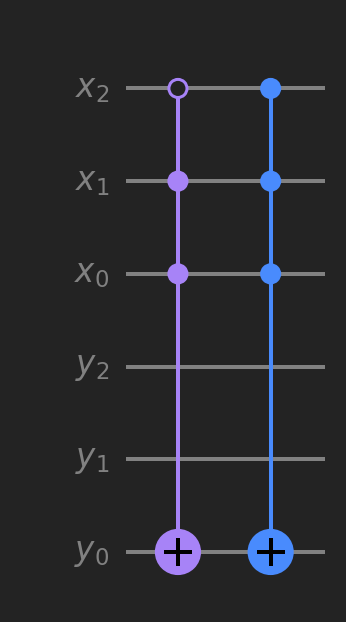

In [16]:
n = 3

xr = QuantumRegister(n, name='x')
yr = QuantumRegister(n, name='y')

qc_bool = QuantumCircuit(yr, xr)
qc_bool.mcx(xr,yr[0],ctrl_state='011')
qc_bool.mcx(xr,yr[0],ctrl_state='111')
qc_bool.draw()

This circuit guarantees that when $x$ is either '011' or '111', qubit $y_0$ will evaluate to $f(x)_0 = 1.$ All that's left is to repeat this process for $f(x)_1, f(x)_2:$

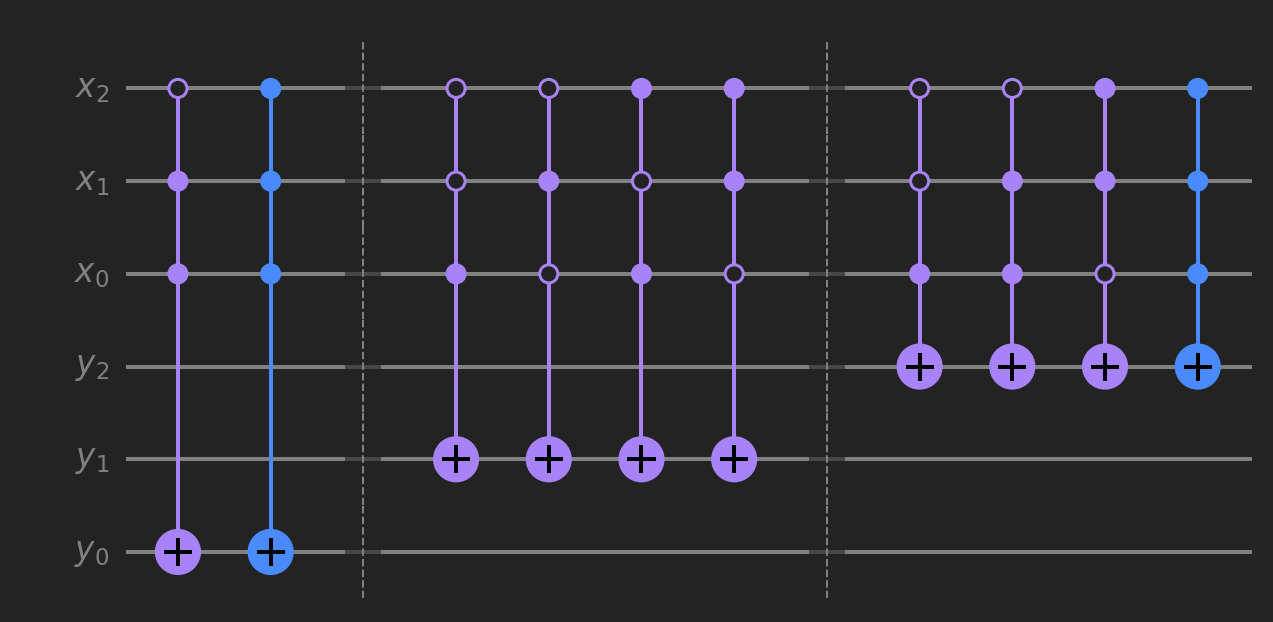

In [17]:
qc_bool.barrier()
qc_bool.mcx(xr,yr[1],ctrl_state='001')
qc_bool.mcx(xr,yr[1],ctrl_state='010')
qc_bool.mcx(xr,yr[1],ctrl_state='101')
qc_bool.mcx(xr,yr[1],ctrl_state='110')
qc_bool.barrier()
qc_bool.mcx(xr,yr[2],ctrl_state='001')
qc_bool.mcx(xr,yr[2],ctrl_state='011')
qc_bool.mcx(xr,yr[2],ctrl_state='110')
qc_bool.mcx(xr,yr[2],ctrl_state='111')
qc_bool.draw()

Let's confirm that this circuit does return the expected values of $f(x)$ for each input $x:$

In [18]:
# Evaluate constant f(x) for all possible |x⟩ inputs with |y⟩=|0⟩:
y = Statevector.from_label('000')
print_func_eval(n, y, qc_bool)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The function `black_box` that we defined in [section 1](#1.-Classical-Approach), performs the same steps we described above but for a random Simon's function (generated by `fx_simon`) with an arbitrary number of qubits.

The issue with this approach is that it generates very inefficient circuits. Since we didn't simplify any of the Boolean expressions extracted from the truth table, we end up with either redundant $MCX$ gates, or with gates that have unnecessary control signals. For instance, in the example above, the expression for $f(x)_0$ can be simplified as:

$$
\begin{aligned}
f(x)_0 &= \left( \overline{x_2} \land x_1 \land x_0 \right) \lor \left(x_2 \land x_1 \land x_0 \right)
\\
\\
f(x)_0 &= x_1 \land x_0 .
\end{aligned}
$$

This means that, instead of needing two 3-control $MCX$ gates, we can perform the same operation with one 2-control unitary.

Ideally, a good circuit transpiler should be able to simplify these circuits for us; unfortunately, the current qiskit transpiler is not capable of doing this automatically. So we can either create our own function to perform these simplifications, or use a python library like `sympy` to do the job. Let's go over an example using the same $f(x)$ we defined above:

In [19]:
from sympy import symbols
from sympy.logic.boolalg import SOPform

In [20]:
n = 3                         # number of qubits
x_vars = ['x2', 'x1', 'x0']   # list of x inputs as strings
x_symbs = symbols(x_vars)     # list of x inputs as symbols
fx_expr_lst = []              # List to store fx expressions
fx_x_lst = []                 # List to store x values in each fx expression

In [21]:
# Simplify f(x)_0
fx_0 = [[0, 1, 1],
        [1, 1, 1],]

expr = SOPform(x_symbs, fx_0)
fx_expr_lst.append(expr)
fx_x_lst.append(expr.free_symbols)
fx_expr_lst[0]

x0 & x1

In [22]:
# Simplify f(x)_1
fx_1 = [[0, 0, 1],
        [0, 1, 0],
        [1, 0, 1],
        [1, 1, 0]]

expr = SOPform(x_symbs, fx_1)
fx_expr_lst.append(expr)
fx_x_lst.append(expr.free_symbols)
fx_expr_lst[1]

(x0 & ~x1) | (x1 & ~x0)

In [23]:
# Simplify f(x)_2
fx_2 = [[0, 0, 1],
        [0, 1, 1],
        [1, 1, 0],
        [1, 1, 1]]

expr = SOPform(x_symbs, fx_2)
fx_expr_lst.append(expr)
fx_x_lst.append(expr.free_symbols)
fx_expr_lst[2]

(x1 & x2) | (x0 & ~x2)

Now we have 3 simplified expressions for $f(x),$ but they are in symbolic form! We will need to turn them back into strings of zeros and ones to define the control signals of our $MCX$ gates. Furthermore, there could be situations in which an expression always evaluates to $1$ or $0,$ which means we will need logic to decide when to add an $MCX,$ an $X,$ or no gate at all. Fortunately, we can avoid this by using qiskit's `BitFlipOracleGate` which takes a function as a input string, and produces the black box we need:

In [24]:
from qiskit.circuit.library import BitFlipOracleGate

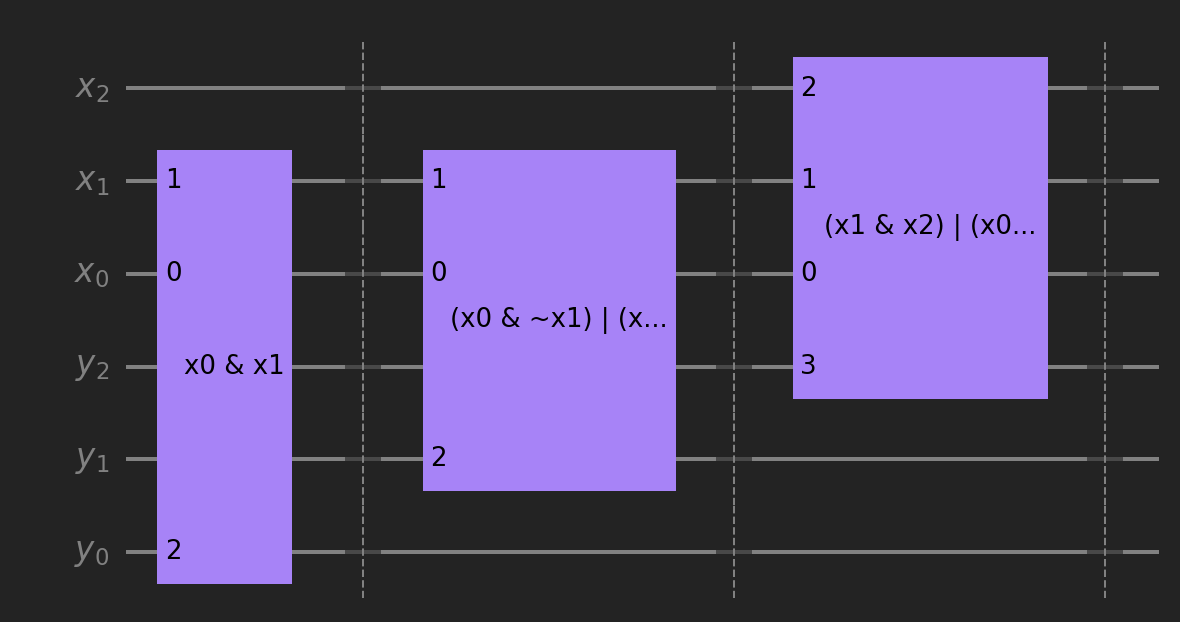

In [25]:
n = 3

xr = QuantumRegister(n, name='x')
yr = QuantumRegister(n, name='y')

qc_bool = QuantumCircuit(yr, xr)

for i in range(n):
    fx_expr = str(fx_expr_lst[i])
    x_in_fx = sorted([int(str(symbol)[1:]) for symbol in fx_x_lst[i]])
    x_qubits = [q+n for q in x_in_fx] + [i]
    qc_bool.append(BitFlipOracleGate(fx_expr, x_vars), x_qubits)
    qc_bool.barrier()
    
qc_bool.draw()

If we look inside each of the `BitFlipOracleGate` gates, we can see the complete simplified black box circuit:

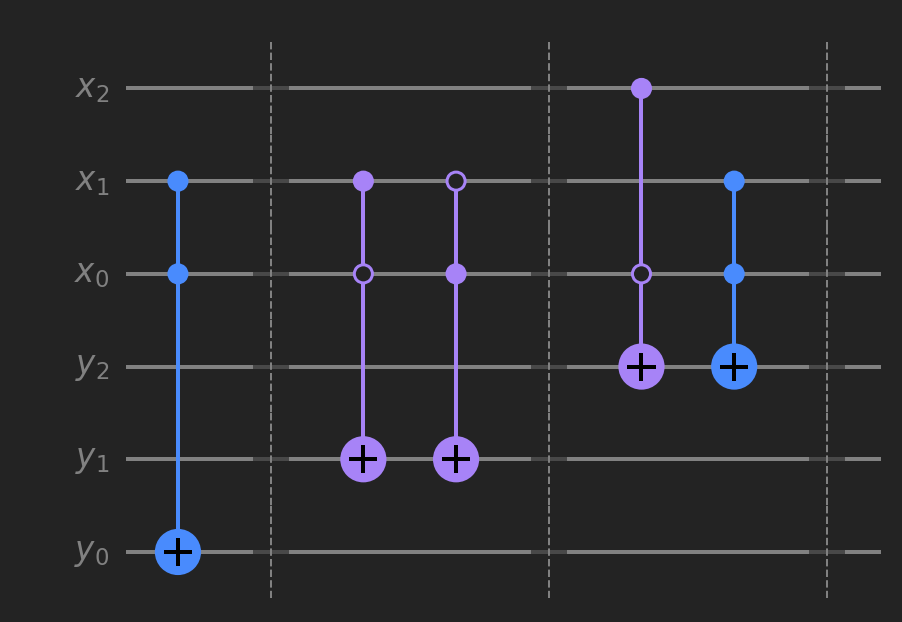

In [26]:
qc_bool.decompose().draw()

Finally, we can modify the original `black_box` function from [section 1](#1.-Classical-Approach) to generate more efficient black box circuits that run faster for large numbers of qubits:

In [27]:
def fx_expr_gen(s_int, n):
    # Generates symbolic logic expressions for each fx_i   
    
    fx_minterms = [[] for _ in range(n)]  # List to store input assignments of each fx_i that evaluates to 1
    fx_expr_lst = []                      # List to store boolean expression strings
    fx_x_lst = []                         # List to store indices of x values for each fx_i in fx_expr_lst
     
    fx_lst = fx_simon(s_int, n)
    
    # Iterate over list where index is x, value is integer value of fx
    # and find the minterms for each fx_i (values of x at which each fx_i evaluates to 1)
    for x_int, fx in enumerate(fx_lst):
        for bit, fx_bit in enumerate(reversed(np.binary_repr(fx, n))):
            if fx_bit == '1':
                fx_minterms[bit].append(x_int)
    
    # list of sympy variables for each x_i
    x_vars = symbols(''.join(f'x{i} ' for i in reversed(range(n))))

    # generate symbolic logic expression (sum of products) for each fx_i
    # fx_x_lst is the list of indices for the x_i values in each fx_i (need this bc qiskit needs the qubit values)
    for minterms in fx_minterms:
        expr = SOPform(x_vars, minterms)
        fx_expr_lst.append(str(expr))
        x_in_fx = sorted([int(str(symbol)[1:]) for symbol in list(expr.free_symbols)])
        fx_x_lst.append(x_in_fx)
        
    return fx_x_lst, fx_expr_lst

In [28]:
def black_box_simp(n):
    s_int = np.random.randint(1, 2**n)
    s = np.binary_repr(s_int, n)
    
    variables = [f'x{q}' for q in range(n)]
    fx_x_lst, fx_expr_lst = fx_expr_gen(s_int, n)
    
    qc_bb = QuantumCircuit(2*n)
    for i in range(n):
        fx_expr = fx_expr_lst[i]
        x_qubits = [q+n for q in fx_x_lst[i]] + [i]

        qc_bb.append(BitFlipOracleGate(fx_expr,variables),x_qubits)
        qc_bb.barrier()
        
    return qc_bb, s

secret string: 100


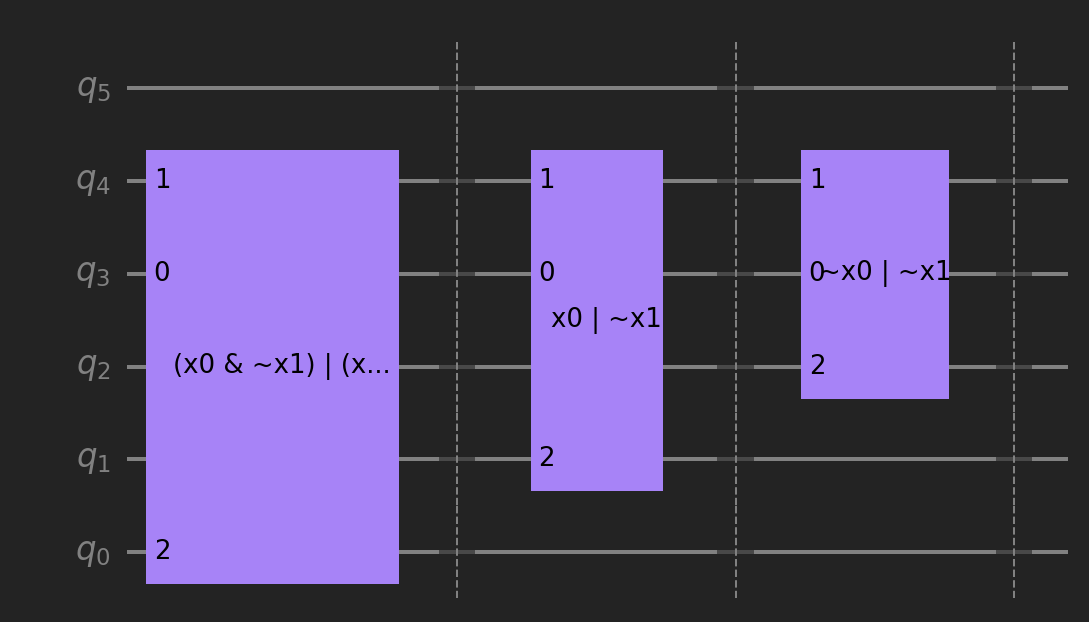

In [29]:
# Draw example of black box circuit for n qubits
n = 3
qc, s = black_box_simp(n)
print(f'secret string: {s}')
qc.draw()

## Footnotes

<a name="footnote1"></a><span style="font-size: smaller;">$^*$The definition of Simon's problem is actually broader than what is described above. More generally, Simon's problem considers an $n$ to $m$ function $f: \{0, 1\}^n \longmapsto \{0, 1\}^n, \, m \geq n,$ which meets the condition $f(x) = f(s \oplus x).$ The function is either one-to-one (when $s$ is the all-zeros string) or two-to-one (when $s$ is any other string). Simon's decision problem consists of finding which of these two types of function $f(x)$ is. Simon's no-decision problem consists in finding what the bit-string $s$ is, which is what is described in this chapter for the case in which $m = n.$ ([go back](#back1))</span>